# Protein abundance change

This notebook runs the analyses on protein abundance changes between variant and reference alleles using Cell Painting assays

In [2]:
### imports
import os
import polars as pl
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

## Disable truncation globally
# pl.Config.set_tbl_rows(20)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns
%matplotlib inline

PLATEMAP_DIR = "../../../8.2_updated_snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
PROF_DIR = "../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles"
LOG_DIR = "../../../8.2_updated_snakemake_pipeline/outputs/classification_results"

# ## define control types
# TC = ["EGFP"]
# NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
# PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
# cNC = ["Renilla"]
# cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
#        "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]

In [3]:
BIO_REP_BATCHES = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]
OUTPUT_DIR = "../../outputs/2025_01_Batch_13-14"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## XGB classifier metrics

In [ ]:
# Paths
metrics_dir = "../../../8.2_updated_snakemake_pipeline/outputs/analyses/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells"

metrics_df, metrics_wtvar = pl.DataFrame(), pl.DataFrame()
for batch in BIO_REP_BATCHES:
    met_dir = metrics_dir.format(batch)
    metrics_df_batch = pl.read_csv(f"{met_dir}/metrics.csv")
    metrics_wtvar_batch = pl.read_csv(f"{met_dir}/metrics_summary.csv")

    metrics_df = pl.concat([metrics_df, metrics_df_batch])
    metrics_wtvar = pl.concat([metrics_wtvar, metrics_wtvar_batch])

In [6]:
## get the localization metrics
local_wtvar = metrics_wtvar.filter(pl.col("Classifier_type") == "localization")

## get the alleles and their reference genes
local_wtvar = local_wtvar.with_columns(
    pl.when(pl.col("AUROC_mean") > pl.col("AUROC_thresh"))
    .then(1)
    .otherwise(0)
    .alias("mislocalized")
).unique()
misloc_alleles = (
    local_wtvar
    .select("allele_0")
    .to_series()
    .to_list()
)
misloc_wt = (
    local_wtvar
    .with_columns(pl.col("allele_0").str.replace("_.*", "").alias("wt"))
    .select("wt")
    .to_series()
    .unique()
    .to_list()
)
all_alleles = misloc_alleles + misloc_wt

## get individual classifiers pass the training imbalance threshold
ind_class = metrics_df.filter(
    (~pl.col("Metadata_Control"))
    & (pl.col("Training_imbalance") < thresh)
    & (
        (pl.col("Full_Classifier_ID").str.contains("true"))
        & pl.col("allele_0").is_in(misloc_alleles)
    )
)

## CellProfiler Features

### Get the CP features for cells that passed the QC

In [7]:
pass_qc_prof_dir = "../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect.parquet"

# Get meta features
b7_alleles = (
    pl.scan_parquet(
        pass_qc_prof_dir.format(batches[0])
    )
    .filter(pl.col("Metadata_gene_allele").is_in(all_alleles))
    .with_columns(
        pl.concat_str(
            [
                "Metadata_Plate",
                "Metadata_Well",
                "Metadata_ImageNumber",
                "Metadata_ObjectNumber",
            ],
            separator="_",
        ).alias("Metadata_CellID")
    )
    .select([
        "Metadata_CellID",
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)

b8_alleles = (
    pl.scan_parquet(
        pass_qc_prof_dir.format(batches[1])
    )
    .filter(pl.col("Metadata_gene_allele").is_in(all_alleles))
    .with_columns(
        pl.concat_str(
            [
                "Metadata_Plate",
                "Metadata_Well",
                "Metadata_ImageNumber",
                "Metadata_ObjectNumber",
            ],
            separator="_",
        ).alias("Metadata_CellID")
    )
    .select([
        "Metadata_CellID",
        "Metadata_gene_allele",
        "Metadata_Well",
        "Metadata_Plate",
    ])
)

cell_alleles = pl.concat([b7_alleles.collect(), b8_alleles.collect()])

### Get the Cells_Intensity CP features per all cells

Merge the Cells_Intensity features to the pass-QC cells

In [8]:
prof_dir = "../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles/{}/profiles.parquet"

b7_prof = pl.scan_parquet(
    prof_dir.format(batches[0])
).with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
)
b8_prof = pl.scan_parquet(
    prof_dir.format(batches[1])
).with_columns(
    pl.concat_str(
        [
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_ImageNumber",
            "Metadata_ObjectNumber",
        ],
        separator="_",
    ).alias("Metadata_CellID")
)

gfp_int = [i for i in b7_prof.collect_schema().names() if "Cells_Intensity" in i]
gfp_int = ["Metadata_CellID"] + [i for i in gfp_int if "GFP" in i]

profiles = pl.concat([
    b7_prof.select(gfp_int).collect(),
    b8_prof.select(gfp_int).collect(),
])

# This method of joining ensures that only cells past filters are included in the abundance analysis
profiles = cell_alleles.join(profiles, on="Metadata_CellID", how="left")

### Aggregate the cells to well profiles

In [9]:
well_profiles = (
    profiles.group_by(["Metadata_Plate", "Metadata_Well", "Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in profiles.columns
        if not col.startswith("Metadata_")
    )
    # .drop("Metadata_CellID")
    .unique()
)

well_profiles

Metadata_Plate,Metadata_Well,Metadata_gene_allele,Cells_Intensity_IntegratedIntensityEdge_GFP,Cells_Intensity_IntegratedIntensity_GFP,Cells_Intensity_LowerQuartileIntensity_GFP,Cells_Intensity_MADIntensity_GFP,Cells_Intensity_MassDisplacement_GFP,Cells_Intensity_MaxIntensityEdge_GFP,Cells_Intensity_MaxIntensity_GFP,Cells_Intensity_MeanIntensityEdge_GFP,Cells_Intensity_MeanIntensity_GFP,Cells_Intensity_MedianIntensity_GFP,Cells_Intensity_MinIntensityEdge_GFP,Cells_Intensity_MinIntensity_GFP,Cells_Intensity_StdIntensityEdge_GFP,Cells_Intensity_StdIntensity_GFP,Cells_Intensity_UpperQuartileIntensity_GFP
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""2025_01_28_B14A7A8P2_T3""","""E02""","""SDHD_Gly138Val""",0.691702,24.25479,0.001726,0.000429,4.583721,0.008535,0.023345,0.00201,0.003638,0.002069,0.001314,0.001282,0.000986,0.003306,0.004092
"""2025_01_27_B13A7A8P2_T4""","""F23""","""CCM2_Thr394Ser""",3.612138,142.110021,0.01119,0.00614,4.108611,0.036633,0.051977,0.009975,0.019139,0.017648,0.002001,0.001909,0.008007,0.009647,0.024927
"""2025_01_28_B14A7A8P1_T2""","""C17""","""BRCA1_Thr581Ala""",1.222176,31.202673,0.003062,0.001174,3.200748,0.010029,0.012527,0.0036,0.004723,0.004209,0.001633,0.001585,0.001853,0.002063,0.005862
"""2025_01_27_B13A7A8P2_T4""","""F07""","""CCM2_Glu201Asp""",3.989769,142.687637,0.011695,0.006271,4.155358,0.038826,0.050843,0.011206,0.019761,0.017953,0.002072,0.001979,0.008898,0.009314,0.026041
"""2025_01_27_B13A7A8P2_T1""","""B09""","""CCM2_Ala205Asp""",4.927729,152.56764,0.012798,0.006118,4.192791,0.042659,0.061156,0.012947,0.020252,0.018865,0.002336,0.00222,0.008974,0.009827,0.026729
"""2025_01_28_B14A7A8P2_T2""","""G03""","""RAD51D_Gly289Ser""",1.004058,31.001469,0.003052,0.001106,3.276336,0.007022,0.012443,0.003023,0.004775,0.004267,0.001517,0.001492,0.001196,0.002102,0.005789
"""2025_01_28_B14A7A8P1_T4""","""K05""","""BRAF_Gly464Val""",18.462262,395.123097,0.051207,0.026916,4.602109,0.195315,0.270693,0.058178,0.083781,0.077051,0.003837,0.003812,0.04186,0.041513,0.108383
"""2025_01_27_B13A7A8P2_T2""","""E01""","""RAD51D_Val132Ile""",1.163114,37.227978,0.003411,0.001425,3.836772,0.008272,0.015533,0.003401,0.00546,0.004765,0.001535,0.001504,0.001473,0.002605,0.006776
"""2025_01_28_B14A7A8P2_T2""","""O14""","""CCM2_Arg52Cys""",2.975032,119.453311,0.010317,0.005765,4.138704,0.030972,0.049501,0.008295,0.017299,0.015317,0.001816,0.001788,0.006681,0.008925,0.022597


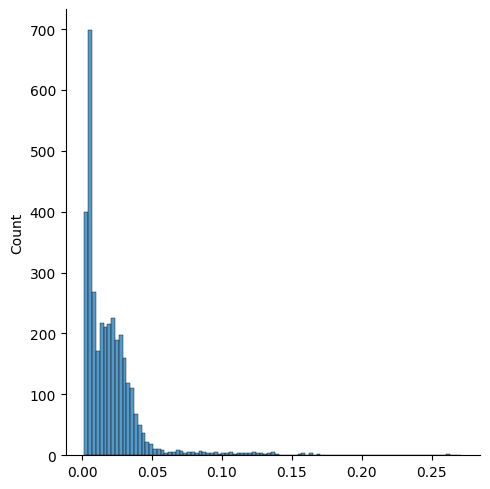

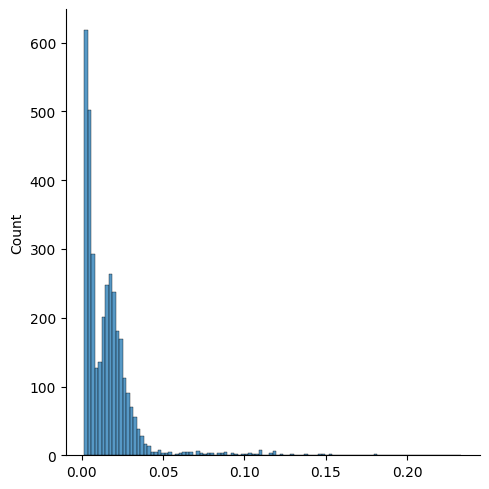

In [11]:
sns.displot(well_profiles["Cells_Intensity_MeanIntensity_GFP"])
sns.displot(well_profiles["Cells_Intensity_MedianIntensity_GFP"])

## Calculate abundance hits

Use paired t-test to call abundance hits

In [12]:
from scipy.stats import shapiro
import re
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
import pandas as pd


# Convert letter rows to numbers
def well_to_coordinates(well):
    row_letter, col_number = re.match(r"([A-P])(\d{2})", well).groups()
    row_index = ord(row_letter) - ord('A') + 1  # Convert 'A'->1, 'B'->2, ..., 'P'->16
    col_index = int(col_number)  # Convert string column to integer
    return well, row_index, col_index


# Compute distances from edges and find the most centered well
def compute_distance(row, col):
    return min(row - 1, 16 - row, col - 1, 24 - col)  # Distance from nearest edge

In [ ]:
## Abundance recalculation test: by Cell MeanIntensity

def paired_ttest(dat, reference: str, var: str, intensity_type: str="Cells_Intensity_IntegratedIntensity_GFP"):
    ## perform stat test
    dat = dat.dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])

    # Assuming well_abun_stats is a DataFrame with columns 'reference_abundance' and 'variant_abundance'
    reference_abundance = dat[dat["Metadata_gene_allele"]==reference][intensity_type].values
    variant_abundance = dat[dat["Metadata_gene_allele"]==var][intensity_type].values
    t_stat, p_val = ttest_rel(variant_abundance, reference_abundance)

    # Calculate Cohen's d
    mean_diff = np.mean(variant_abundance) - np.mean(reference_abundance)
    pooled_std = np.sqrt((np.std(variant_abundance, ddof=1) ** 2 + np.std(reference_abundance, ddof=1) ** 2) / 2)
    cohen_d = mean_diff / pooled_std
    summary_df = pl.DataFrame(
        {
            "t_stat": t_stat,
            "p_val": p_val,
            "cohen_d": cohen_d
        }
    )
    summary_df = summary_df.with_columns(
        pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
    )
    return summary_df


well_abun_stats = []
for allele in tqdm(misloc_alleles):
    temp_class = ind_class.filter(pl.col("allele_0") == allele)
    temp_prof = well_profiles.filter(
        (pl.col("Metadata_Plate").is_in(temp_class.select("Plate").to_series()))
        & (
            pl.col("Metadata_Well").is_in(temp_class.select("well_1"))
            | pl.col("Metadata_Well").is_in(temp_class.select("well_0"))
        )
    )
    reference = allele.split("_")[0]

    temp_prof = temp_prof.to_pandas().dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
    var_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==allele]
    ref_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==reference]
    
    # print(temp_prof)
    # diff = temp_prof[temp_prof["Metadata_gene_allele"]==allele]["Cells_Intensity_IntegratedIntensityEdge_GFP"].values - \
    #        temp_prof[temp_prof["Metadata_gene_allele"]==reference]["Cells_Intensity_IntegratedIntensityEdge_GFP"].values

    # try:
    if (ref_profiles.shape[0] > var_profiles.shape[0]):
        ref_al_wells = ref_profiles["Metadata_Well"].unique()
        well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
        # Sort wells by max distance from edges (descending)
        most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
        ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Well"]==most_centered_well)]
        
    if (ref_profiles.shape[0] < var_profiles.shape[0]):
        ref_al_wells = var_profiles["Metadata_Well"].unique()
        well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
        # Sort wells by max distance from edges (descending)
        most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
        var_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==allele)&(temp_prof["Metadata_Well"]==most_centered_well)]

    well_abun_stats.append(
        paired_ttest(
            dat=pd.concat([ref_profiles, var_profiles]),
            reference=reference,
            var=allele
        )
    )

well_abun_stats = pl.concat(well_abun_stats, how="vertical")
well_abun_stats = well_abun_stats.rename({"t_stat": "U2OS_t"})
well_abun_stats = well_abun_stats.sort(["Gene", "Variant", "U2OS_t", "p_val", "cohen_d"])
well_abun_stats

100%|██████████| 1126/1126 [00:46<00:00, 23.98it/s]


U2OS_t,p_val,cohen_d,Gene,Variant
f64,f64,f64,str,str
-0.502747,0.649729,-0.201226,"""ACACB""","""ACACB_Val958Met"""
-7.320941,0.005264,-3.816329,"""ACSF3""","""ACSF3_Ala197Thr"""
-3.236187,0.04799,-1.417801,"""ACSF3""","""ACSF3_Arg10Trp"""
-8.15496,0.000081,-1.898847,"""ACSF3""","""ACSF3_Arg471Trp"""
-8.15496,0.000081,-1.898847,"""ACSF3""","""ACSF3_Arg471Trp"""
-8.500581,0.000062,-2.261558,"""ACSF3""","""ACSF3_Arg558Trp"""
-8.500581,0.000062,-2.261558,"""ACSF3""","""ACSF3_Arg558Trp"""
-5.802279,0.000662,-1.998218,"""ACSF3""","""ACSF3_Asp457Asn"""
-5.802279,0.000662,-1.998218,"""ACSF3""","""ACSF3_Asp457Asn"""


In [ ]:
well_abun_stats.write_csv(f"../../outputs/2025_01_Batch_13-14/well-level_prot-abundance_changes.csv")

In [ ]:
# def paired_ttest(dat, reference: str, var: str):
#     ## perform stat test
#     dat = dat.dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])

#     # Assuming well_abun_stats is a DataFrame with columns 'reference_abundance' and 'variant_abundance'
#     reference_abundance = dat[dat["Metadata_gene_allele"]==reference]["Cells_Intensity_MedianIntensity_GFP"].values
#     variant_abundance = dat[dat["Metadata_gene_allele"]==var]["Cells_Intensity_MedianIntensity_GFP"].values
#     t_stat, p_val = ttest_rel(variant_abundance, reference_abundance)

#     # Calculate Cohen's d
#     mean_diff = np.mean(variant_abundance) - np.mean(reference_abundance)
#     pooled_std = np.sqrt((np.std(variant_abundance, ddof=1) ** 2 + np.std(reference_abundance, ddof=1) ** 2) / 2)
#     cohen_d = mean_diff / pooled_std
#     summary_df = pl.DataFrame(
#         {
#             "t_stat": t_stat,
#             "p_val": p_val,
#             "cohen_d": cohen_d
#         }
#     )
#     summary_df = summary_df.with_columns(
#         pl.lit(reference).alias("Gene"), pl.lit(var).alias("Variant")
#     )
#     return summary_df



# well_abun_stats = []
# for allele in tqdm(misloc_alleles):
#     temp_class = ind_class.filter(pl.col("allele_0") == allele)
#     temp_prof = well_profiles.filter(
#         (pl.col("Metadata_Plate").is_in(temp_class.select("Plate").to_series()))
#         & (
#             pl.col("Metadata_Well").is_in(temp_class.select("well_1"))
#             | pl.col("Metadata_Well").is_in(temp_class.select("well_0"))
#         )
#     )
#     reference = allele.split("_")[0]

#     temp_prof = temp_prof.to_pandas().dropna().sort_values(["Metadata_Plate","Metadata_gene_allele"])
#     var_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==allele]
#     ref_profiles = temp_prof[temp_prof["Metadata_gene_allele"]==reference]
    
#     # print(temp_prof)
#     # diff = temp_prof[temp_prof["Metadata_gene_allele"]==allele]["Cells_Intensity_IntegratedIntensityEdge_GFP"].values - \
#     #        temp_prof[temp_prof["Metadata_gene_allele"]==reference]["Cells_Intensity_IntegratedIntensityEdge_GFP"].values

#     # try:
#     if (ref_profiles.shape[0] > var_profiles.shape[0]):
#         ref_al_wells = ref_profiles["Metadata_Well"].unique()
#         well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
#         # Sort wells by max distance from edges (descending)
#         most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
#         ref_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==reference)&(temp_prof["Metadata_Well"]==most_centered_well)]
        
#     if (ref_profiles.shape[0] < var_profiles.shape[0]):
#         ref_al_wells = var_profiles["Metadata_Well"].unique()
#         well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in ref_al_wells])]
#         # Sort wells by max distance from edges (descending)
#         most_centered_well = max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]
#         var_profiles = temp_prof[(temp_prof["Metadata_gene_allele"]==allele)&(temp_prof["Metadata_Well"]==most_centered_well)]

#     well_abun_stats.append(
#         paired_ttest(
#             dat=pd.concat([ref_profiles, var_profiles]),
#             reference=reference,
#             var=allele
#         )
#     )

# well_abun_stats = pl.concat(well_abun_stats, how="vertical")
# well_abun_stats = well_abun_stats.rename({"t_stat": "U2OS_t"})
# well_abun_stats = well_abun_stats.sort(["Gene", "Variant", "U2OS_t", "p_val", "cohen_d"])
# well_abun_stats

100%|██████████| 1126/1126 [00:44<00:00, 25.33it/s]


U2OS_t,p_val,cohen_d,Gene,Variant
f64,f64,f64,str,str
1.045202,0.372731,0.421038,"""ACACB""","""ACACB_Val958Met"""
-7.045782,0.005876,-2.871654,"""ACSF3""","""ACSF3_Ala197Thr"""
-3.177852,0.050177,-1.535075,"""ACSF3""","""ACSF3_Arg10Trp"""
-4.021488,0.00505,-1.550507,"""ACSF3""","""ACSF3_Arg471Trp"""
-4.021488,0.00505,-1.550507,"""ACSF3""","""ACSF3_Arg471Trp"""
-3.393741,0.01154,-1.503345,"""ACSF3""","""ACSF3_Arg558Trp"""
-3.393741,0.01154,-1.503345,"""ACSF3""","""ACSF3_Arg558Trp"""
-3.888603,0.005986,-1.497214,"""ACSF3""","""ACSF3_Asp457Asn"""
-3.888603,0.005986,-1.497214,"""ACSF3""","""ACSF3_Asp457Asn"""


## Compare with DUAL-IPA

In [24]:
dualipa_outputs = "../../../dual_ipa/3_outputs"
pDEST_DUAL_avg_allele_df = pl.read_csv(f'{dualipa_outputs}/DUALIPA_mean_zscore.tsv', separator='\t')
# pDEST_DUAL_avg_allele_df

dualipa = pl.DataFrame(pDEST_DUAL_avg_allele_df).with_columns(
    pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("Variant")
).select(["Variant", "zscore_log2", "zscore"]).rename({
    "zscore_log2": "dualipa_zscore_log2",
    "zscore": "dualipa_zscore"
})

imaging = well_abun_stats.rename({
    "U2OS_t": "imaging_zscore"
})

abun_df = dualipa.join(imaging, on="Variant").to_pandas()
abun_df = abun_df[abun_df["imaging_zscore"]>-150]
abun_df = abun_df.dropna(subset=["dualipa_zscore_log2","imaging_zscore"])
print(abun_df.shape)

(799, 7)


In [25]:
imaging.filter(pl.col("imaging_zscore")<(-150))

imaging_zscore,p_val,cohen_d,Gene,Variant
f64,f64,f64,str,str
-165.798215,0.00384,-203.147638,"""AGXT""","""AGXT_Arg289His"""


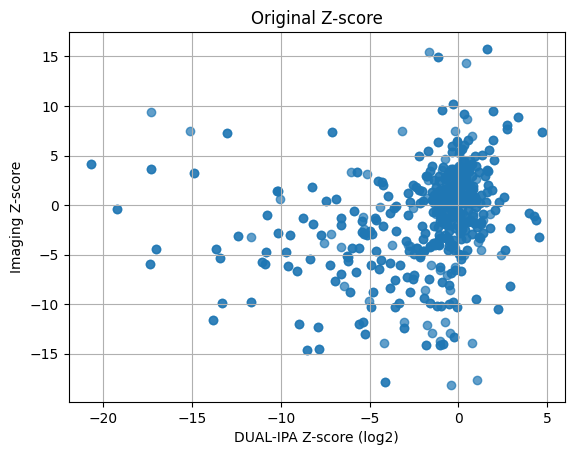

Spearman's correlation: 0.37157183464832444, pval: 1.459388013900544e-27


In [26]:
plt.scatter(abun_df['dualipa_zscore_log2'], abun_df['imaging_zscore'], alpha=0.7)
plt.ylabel('Imaging Z-score')
plt.xlabel('DUAL-IPA Z-score (log2)')
plt.title('Original Z-score')
plt.grid(True)
plt.show()

from scipy.stats import spearmanr

# Calculate the Spearman's correlation between the ranks
spearman_corr, _ = spearmanr(abun_df["dualipa_zscore_log2"], abun_df["imaging_zscore"])
print(f"Spearman's correlation: {spearman_corr}, pval: {_}")

(799, 7)


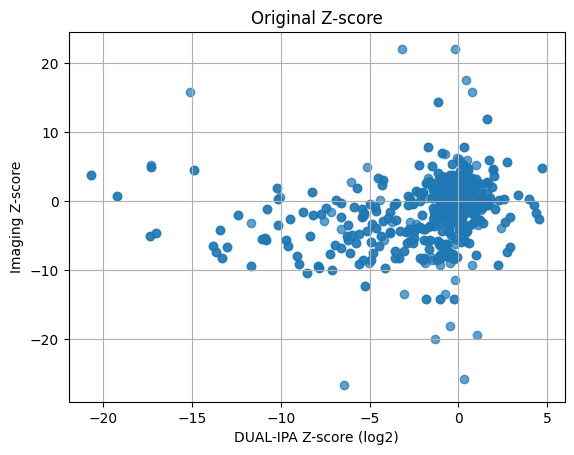

Spearman's correlation: 0.3452102884747514, pval: 8.882493075721076e-24


In [39]:
imaging = well_abun_stats.rename({
    "U2OS_t": "imaging_zscore"
})

abun_df = dualipa.join(imaging, on="Variant").to_pandas()
abun_df = abun_df[(abun_df["imaging_zscore"]<50)&(abun_df["imaging_zscore"]>-40)]
abun_df = abun_df.dropna(subset=["dualipa_zscore_log2","imaging_zscore"])
print(abun_df.shape)

plt.scatter(abun_df['dualipa_zscore_log2'], abun_df['imaging_zscore'], alpha=0.7)
plt.ylabel('Imaging Z-score')
plt.xlabel('DUAL-IPA Z-score (log2)')
plt.title('Original Z-score')
plt.grid(True)
plt.show()

from scipy.stats import spearmanr

# Calculate the Spearman's correlation between the ranks
spearman_corr, _ = spearmanr(abun_df["dualipa_zscore_log2"], abun_df["imaging_zscore"])
print(f"Spearman's correlation: {spearman_corr}, pval: {_}")